In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle 
import torch
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import json
import re

In [4]:
import argparse
import os
import sys
sys.path.append('/u/dbeaglehole/mech_interp/neural_controllers/')

from neural_controllers import NeuralController
from utils import load_model

In [5]:
import pickle

# List of files to process
files = [
    '../toxic_chat_results/openai_gpt-4o_metrics.pkl',
    '../toxic_chat_results/llama_gpt-4o_metrics.pkl',
    '../toxic_chat_results/t5-large-ft_gpt-4o_metrics.pkl',
    '../toxic_chat_results/gemma_gpt-4o_metrics.pkl'
]

# Function to load and print metrics from a pickle file
def load_and_print_metrics(file_path):
    print(f"\nMetrics for {file_path}:")
    print("-" * 50)
    
    try:
        with open(file_path, 'rb') as f:
            metrics = pickle.load(f)
            
        # Print each metric with formatting
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value}")
            
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found")
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")

# Process each file
for file in files:
    load_and_print_metrics(file)


Metrics for ../toxic_chat_results/openai_gpt-4o_metrics.pkl:
--------------------------------------------------
Error: File '../toxic_chat_results/openai_gpt-4o_metrics.pkl' not found

Metrics for ../toxic_chat_results/llama_gpt-4o_metrics.pkl:
--------------------------------------------------
Error: File '../toxic_chat_results/llama_gpt-4o_metrics.pkl' not found

Metrics for ../toxic_chat_results/t5-large-ft_gpt-4o_metrics.pkl:
--------------------------------------------------
Error: File '../toxic_chat_results/t5-large-ft_gpt-4o_metrics.pkl' not found

Metrics for ../toxic_chat_results/gemma_gpt-4o_metrics.pkl:
--------------------------------------------------
Error: File '../toxic_chat_results/gemma_gpt-4o_metrics.pkl' not found


In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['pca', 'rfm', 'linear', 'logistic']
# methods += ['linear_sample_weight_inverse', 'rfm_linear_sample_weight_inverse', 'linear_rfm_sample_weight_inverse', 'rfm_sample_weight_inverse', 'logistic_sample_weight_inverse']
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../toxic_chat_results/llama_3_8b_it_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'../toxic_chat_results/llama_3_8b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Test Metrics (Selected by Best Validation Layer):

PCA:
acc: 92.5792 ± 0.0401
precision: 0.4329 ± 0.0099
recall: 0.0984 ± 0.0035
f1: 0.1603 ± 0.0046

RFM:
acc: 95.3059 ± 0.3335
precision: 0.8426 ± 0.0144
recall: 0.4290 ± 0.0600
f1: 0.5656 ± 0.0535

LINEAR:
acc: 95.8725 ± 0.1371
precision: 0.8398 ± 0.0094
recall: 0.5273 ± 0.0179
f1: 0.6477 ± 0.0151

LOGISTIC:
acc: 95.6246 ± 0.1547
precision: 0.8575 ± 0.0232
recall: 0.4710 ± 0.0194
f1: 0.6077 ± 0.0170


In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']
# methods += ['linear_sample_weight_inverse', 'rfm_linear_sample_weight_inverse', 'linear_rfm_sample_weight_inverse', 'rfm_sample_weight_inverse', 'logistic_sample_weight_inverse']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../toxic_chat_results/llama_3_8b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")


Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 96.1873 ± 0.1037
precision: 0.8409 ± 0.0076
recall: 0.5803 ± 0.0165
f1: 0.6866 ± 0.0117

RFM:
acc: 96.1204 ± 0.1685
precision: 0.7471 ± 0.0191
recall: 0.6984 ± 0.0140
f1: 0.7217 ± 0.0101

LOGISTIC:
acc: 96.0732 ± 0.0578
precision: 0.8615 ± 0.0094
recall: 0.5421 ± 0.0166
f1: 0.6652 ± 0.0101

RFM_LINEAR:
acc: 95.8607 ± 0.2812
precision: 0.8409 ± 0.0136
recall: 0.5240 ± 0.0404
f1: 0.6449 ± 0.0330

LINEAR_RFM:
acc: 96.2345 ± 0.1235
precision: 0.7567 ± 0.0077
recall: 0.7038 ± 0.0364
f1: 0.7287 ± 0.0160


## Gemma-2-9b-it

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['pca', 'rfm', 'linear', 'logistic']


# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../toxic_chat_results/gemma_2_9b_it_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'../toxic_chat_results/gemma_2_9b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Test Metrics (Selected by Best Validation Layer):

PCA:
acc: 94.0468 ± 0.3717
precision: 0.6913 ± 0.0694
recall: 0.3519 ± 0.1582
f1: 0.4381 ± 0.1250

RFM:
acc: 95.7466 ± 0.1044
precision: 0.8500 ± 0.0197
recall: 0.4978 ± 0.0215
f1: 0.6274 ± 0.0145

LINEAR:
acc: 96.0496 ± 0.2128
precision: 0.8347 ± 0.0178
recall: 0.5628 ± 0.0246
f1: 0.6721 ± 0.0210

LOGISTIC:
acc: 96.2109 ± 0.1197
precision: 0.8416 ± 0.0130
recall: 0.5842 ± 0.0243
f1: 0.6892 ± 0.0152


In [8]:
print("GEMMA")


import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']
# methods += ['pca', 'linear_rfm_sample_weight_inverse', 'rfm_linear_sample_weight_inverse', 'rfm_sample_weight_inverse',]
# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../toxic_chat_results/gemma_2_9b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")

GEMMA

Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 96.3486 ± 0.0459
precision: 0.8298 ± 0.0049
recall: 0.6202 ± 0.0120
f1: 0.7098 ± 0.0065

RFM:
acc: 95.8214 ± 0.1158
precision: 0.7162 ± 0.0053
recall: 0.6951 ± 0.0216
f1: 0.7053 ± 0.0121

LOGISTIC:
acc: 96.3171 ± 0.0627
precision: 0.8217 ± 0.0114
recall: 0.6246 ± 0.0227
f1: 0.7093 ± 0.0109

RFM_LINEAR:
acc: 96.3132 ± 0.1031
precision: 0.8326 ± 0.0113
recall: 0.6109 ± 0.0110
f1: 0.7047 ± 0.0089

LINEAR_RFM:
acc: 95.7584 ± 0.2369
precision: 0.7126 ± 0.0215
recall: 0.6902 ± 0.0266
f1: 0.7008 ± 0.0170


### Toxicchat-T5-Large

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['pca', 'rfm', 'linear', 'logistic']
# methods = ['linear']

# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../toxic_chat_results/toxicchat-t5-large_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'../toxic_chat_results/toxicchat-t5-large_{method}_seed_{s}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
# methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']
methods = ['linear']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../toxic_chat_results/toxicchat-t5-large_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")

File not found: ../toxic_chat_results/toxicchat-t5-large_linear_seed_1_test_metrics.pkl
File not found: ../toxic_chat_results/toxicchat-t5-large_linear_seed_2_test_metrics.pkl
File not found: ../toxic_chat_results/toxicchat-t5-large_linear_seed_3_test_metrics.pkl
File not found: ../toxic_chat_results/toxicchat-t5-large_linear_seed_4_test_metrics.pkl

Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 92.8192 ± 0.0000
precision: 0.5714 ± 0.0000
recall: 0.0109 ± 0.0000
f1: 0.0214 ± 0.0000

TRIVIAL ACCURACY: 92.7995 ± 0.0000


### Layer-wise plots

layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 'linear_agg'])
layers [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, 'linear_agg'])
layers [-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


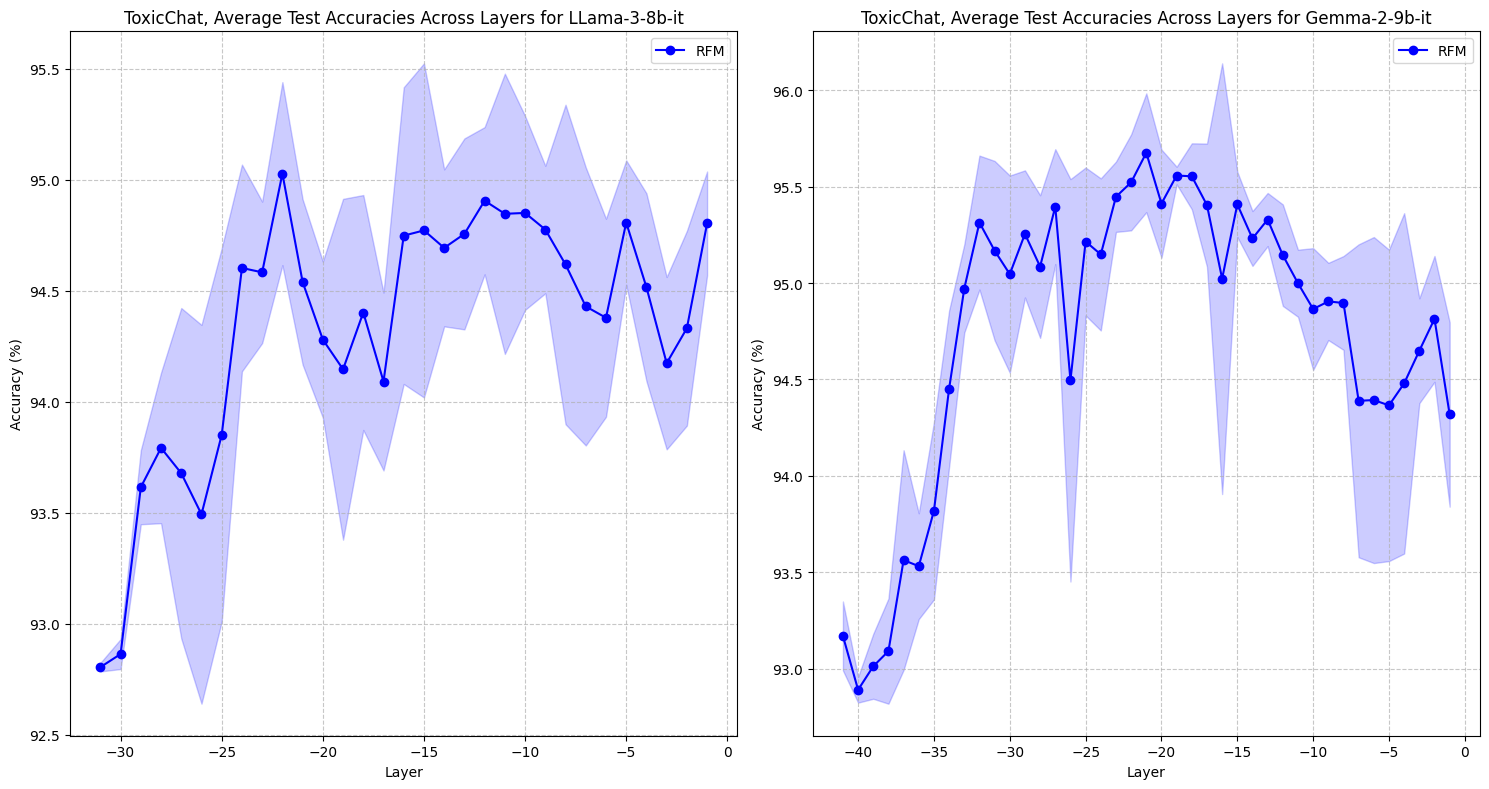

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds
seeds = np.arange(5)
methods = ['rfm']#, 'logistic']
models = ['llama_3_8b', 'gemma_2_9b']

# Initialize dictionaries to store results
all_results = {}

for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'/u/dbeaglehole/mech_interp/neural_controllers/quantitative_comparisons/toxic_chat_results/{model}_it_{method}_seed_{s}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key]['acc'])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        print("layer_data.keys()", layer_data.keys())
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            print("layers", layers)
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    plt.title(f'ToxicChat, Average Test Accuracies Across Layers for {model.replace(model[0], model[0].upper()).replace("_", "-")}-it')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig('toxicchat_test_accuracies_across_layers.pdf', format='pdf')
plt.show()